In [1]:
#extra module installation
!pip3 install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#imports
import time
from glob import glob 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Conv2DTranspose,BatchNormalization,Flatten,Dense,Reshape
from tensorflow.keras import activations 
from tensorflow.keras import optimizers 
import cv2
import math
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split,KFold
import pickle
from patchify import patchify, unpatchify
import random
from prettytable import PrettyTable

In [3]:
#global variables
SIGMA=25
EPOCHS=50
LR=1e-3
BATCH_SIZE=128

In [4]:
#link the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/train.zip

### comparative analysis


In [16]:
#calculate mse between two images
def mse(imageA,imageB):
    mse_error=np.sum((imageA.astype("float")-imageB.astype("float"))**2)
    mse_error /= float(imageA.shape[0] * imageA.shape[1])
    
    #return the MSE . the lower the error, the more 'similar' the two images are
    return (mse_error)

In [21]:
#calculate PSNR between two images
def PSNR(imageA,imageB):
    mse_error=mse(imageA,imageB)
    if mse_error ==0 :
        return 100

    max_pixel=1.0
    #higher the PSNR, better the quality 
    psnr=20*math.log10(max_pixel/np.sqrt(mse_error))
    return psnr

In [8]:
#function to compare the images
def compare_images(imageA,imageB):
    #calculate MSE and SSIM
    m=mse(imageA,imageB)
    p=PSNR(imageA,imageB)
    s=ssim(imageA,imageB)
    
    #higher the SSIM, the more "similar" two images are
    return [m,p,s]

### Load the dataset

In [9]:
training_files=glob('/content/train/original/*')
GT=[]
noisy=[]
noisy_path='/content/train/noisy/'
for file in training_files:
  a=file.split('/')[-1]
  b=noisy_path+a
  GT.append(file)
  noisy.append(b)

df=pd.DataFrame()
df['ground_truth']=GT
df['noisy']=noisy 
print(df.head())
print(df.shape)


                       ground_truth                          noisy
0  /content/train/original/0219.png  /content/train/noisy/0219.png
1  /content/train/original/0185.png  /content/train/noisy/0185.png
2  /content/train/original/0123.png  /content/train/noisy/0123.png
3  /content/train/original/0105.png  /content/train/noisy/0105.png
4  /content/train/original/0005.png  /content/train/noisy/0005.png
(400, 2)


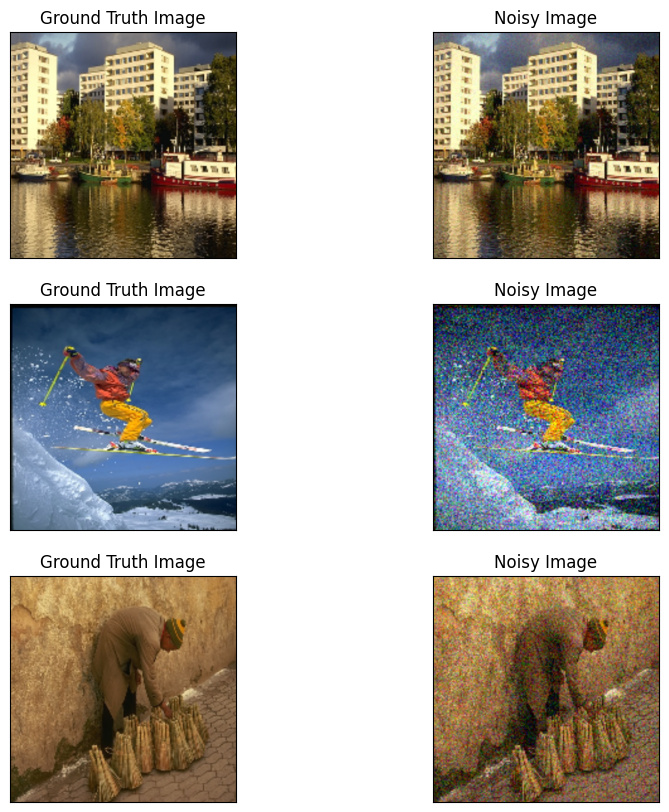

In [23]:
#display few clean-noisy image pairs
sample=df.sample(3)
fig, ax = plt.subplots(len(sample),2,figsize=(10,10))
for i in range(len(sample)):
  img = cv2.imread(sample['ground_truth'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][0].imshow(img)
  ax[i][0].get_xaxis().set_visible(False)
  ax[i][0].get_yaxis().set_visible(False)
  ax[i][0].title.set_text("Ground Truth Image")
  
  img = cv2.imread(sample['noisy'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][1].imshow(img)
  ax[i][1].get_xaxis().set_visible(False)
  ax[i][1].get_yaxis().set_visible(False)
  ax[i][1].title.set_text("Noisy Image")

### Splitting the dataset into train and test datasets

### Create patches from images

### Create patches for X_train and y_train

In [11]:
def patches(img,patch_size):
  patches=patchify(img,(patch_size,patch_size,3),step=patch_size)
  return patches

In [36]:
def psnr_and_ssim(X_test,y_test,model,model_type='Normal',test_68=False):
  psnr_nsy = 0.0
  psnr_de_nsy = 0.0
  ssim_nsy = 0.0
  ssim_de_nsy = 0.0
  psnr_list=[]
  ssim_list=[]
  for i in range(len(X_test)):
    #getting the noisy images
    if test_68:
      path=X_test[i]
    else:
      path = X_test.iloc[i]
    nsy = cv2.imread(path)  
    
    pred = predict(nsy,model,verbose=False)
    # pred=pred.numpy()

    #getting the ground truth images
    if test_68:
      path = y_test[i]
    else:
      path=y_test.iloc[i]
    gt = cv2.imread(path)  




    
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    pred=cv2.cvtColor(pred,cv2.COLOR_BGR2GRAY)
    nsy=cv2.cvtColor(nsy,cv2.COLOR_BGR2GRAY)

    #Resizing the images
    gt = cv2.resize(gt,(256,256))
    nsy = cv2.resize(nsy,(256,256))

    #Normalizing the images
    gt = gt.astype("float32") / 255.0
    nsy = nsy.astype("float32") / 255.0


    #Computing psnr and ssim for test images
    psnr_list.append(PSNR(gt,pred))
    # ssim_list.append(ssim(gt,pred,channel_axis=2,data_range=pred.max()-pred.min()))
    ssim_list.append(ssim(gt,pred))
    psnr_nsy += PSNR(gt,nsy)
    psnr_de_nsy += PSNR(gt,pred)
    ssim_nsy += ssim(gt,nsy)
    ssim_de_nsy += ssim(gt,pred)
    # ssim_nsy += ssim(gt,nsy,channel_axis=2,data_range=nsy.max() - nsy.min())
    # ssim_de_nsy += ssim(gt,pred,channel_axis=2,data_range=pred.max() - pred.min())

  psnr_nsy = psnr_nsy/len(X_test)
  psnr_de_nsy = psnr_de_nsy/len(X_test)
  ssim_nsy = ssim_nsy/len(X_test)
  ssim_de_nsy = ssim_de_nsy/len(X_test)
  return psnr_nsy, psnr_de_nsy,ssim_nsy,ssim_de_nsy,psnr_list,ssim_list

In [13]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, X,y,batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))

    def __getitem__(self, i):
        # collect batch data
        batch_x = self.X[i * self.batch_size : (i+1) * self.batch_size]
        batch_y = self.y[i * self.batch_size : (i+1) * self.batch_size]
        
        return tuple((batch_x,batch_y))
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [17]:

class Autoencoder(Model):
  def __init__(self,latent_dim):
    super(Autoencoder,self).__init__()
    self.latent_dim=latent_dim

    #encoder network
    self.encoder=Sequential([
        Conv2D(32,(3,3),kernel_initializer='he_normal',padding='same',input_shape=(32,32,3)),
        tf.keras.layers.LeakyReLU(),
        MaxPooling2D((2,2),padding='same'),
        # BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        Conv2D(64,(3,3),kernel_initializer='he_normal',padding='same'),
        tf.keras.layers.LeakyReLU(),
        MaxPooling2D((2,2),padding='same'),
        Conv2D(128,(3,3),kernel_initializer='he_normal',padding='same'),
        tf.keras.layers.LeakyReLU(),
        MaxPooling2D((2,2),padding='same')])
        # tf.keras.layers.Dropout(0.2)])

    


    #decoder network
    self.decoder=Sequential([
        Conv2DTranspose(128,(3,3),strides=2,kernel_initializer='he_normal',padding='same'),
        tf.keras.layers.LeakyReLU(),
        Conv2DTranspose(64,(3,3),strides=2,kernel_initializer='he_normal',padding='same'),
        tf.keras.layers.LeakyReLU(),
        Conv2DTranspose(32,(3,3),strides=2,kernel_initializer='he_normal',padding='same'),
        tf.keras.layers.LeakyReLU(),
        Conv2D(3,(3,3),activation='sigmoid',kernel_initializer='he_normal',padding='same')
    ])

  def call(self,x):
    encoded=self.encoder(x)
    decoded=self.decoder(encoded)
    return decoded



############################
#####   SPLIT : 1   #######
############################
(320,)
(320,)
(80,)
(80,)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(5120, 32, 32, 3)
(5120, 32, 32, 3)
Total number of image patches on train data :  (20480, 32, 32, 3)
Total number of image patches on test data :  (5120, 32, 32, 3)
(32, 32, 32, 3)
Epoch 1/50
637/640 [============================>.] - ETA: 0s - loss: 0.0087
Epoch 1: val_loss improved from inf to 0.00625, saving model to training_1/cp.ckpt
640/640 [==============================] - 7s 7ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 2/50
634/640 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 2: val_loss improved from 0.00625 to 0.00464, saving model to training_1/cp.ckpt
640/640 [==============================] - 5s 7ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 3/50
640/640 [==============================] - ETA: 0s - loss: 0.0036
Epoch 3: val_loss did not improve from 0.00464
640/

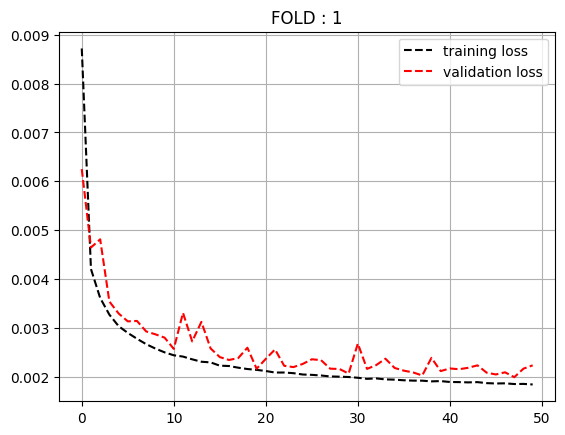

############################
#####   SPLIT : 2   #######
############################
(320,)
(320,)
(80,)
(80,)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(5120, 32, 32, 3)
(5120, 32, 32, 3)
Total number of image patches on train data :  (20480, 32, 32, 3)
Total number of image patches on test data :  (5120, 32, 32, 3)
(32, 32, 32, 3)
Epoch 1/50
640/640 [==============================] - ETA: 0s - loss: 0.0085
Epoch 1: val_loss improved from inf to 0.00838, saving model to training_2/cp.ckpt
640/640 [==============================] - 7s 8ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 2/50
637/640 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 2: val_loss improved from 0.00838 to 0.00454, saving model to training_2/cp.ckpt
640/640 [==============================] - 5s 7ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 3/50
634/640 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 3: val_loss did not improve from 0.00454
640/

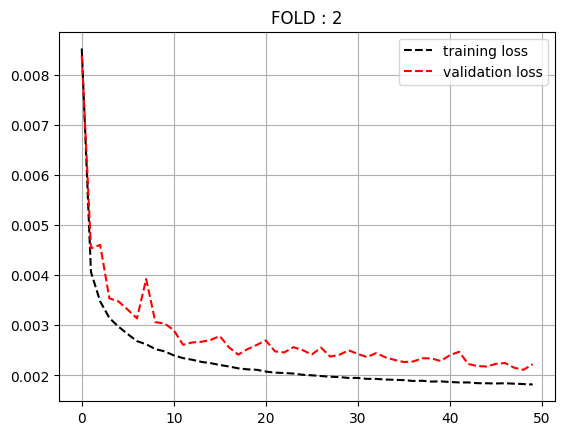

############################
#####   SPLIT : 3   #######
############################
(320,)
(320,)
(80,)
(80,)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(5120, 32, 32, 3)
(5120, 32, 32, 3)
Total number of image patches on train data :  (20480, 32, 32, 3)
Total number of image patches on test data :  (5120, 32, 32, 3)
(32, 32, 32, 3)
Epoch 1/50
631/640 [============================>.] - ETA: 0s - loss: 0.0087
Epoch 1: val_loss improved from inf to 0.00803, saving model to training_3/cp.ckpt
640/640 [==============================] - 7s 8ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 2/50
634/640 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 2: val_loss improved from 0.00803 to 0.00539, saving model to training_3/cp.ckpt
640/640 [==============================] - 4s 6ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 3/50
633/640 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 3: val_loss improved from 0.00539 to 0.00469,

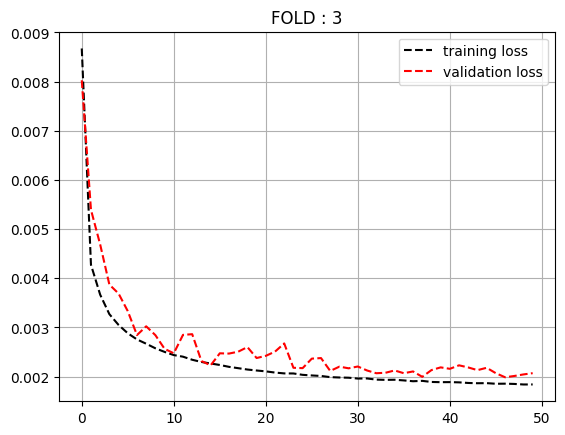

############################
#####   SPLIT : 4   #######
############################
(320,)
(320,)
(80,)
(80,)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(5120, 32, 32, 3)
(5120, 32, 32, 3)
Total number of image patches on train data :  (20480, 32, 32, 3)
Total number of image patches on test data :  (5120, 32, 32, 3)
(32, 32, 32, 3)
Epoch 1/50
635/640 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 1: val_loss improved from inf to 0.00513, saving model to training_4/cp.ckpt
640/640 [==============================] - 8s 8ms/step - loss: 0.0086 - val_loss: 0.0051
Epoch 2/50
636/640 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 2: val_loss did not improve from 0.00513
640/640 [==============================] - 4s 7ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 3/50
638/640 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 3: val_loss improved from 0.00513 to 0.00387, saving model to training_4/cp.ckpt
640/

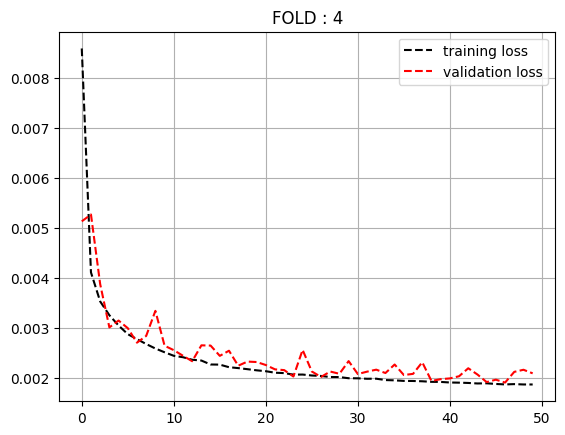

############################
#####   SPLIT : 5   #######
############################
(320,)
(320,)
(80,)
(80,)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(20480, 32, 32, 3)
(5120, 32, 32, 3)
(5120, 32, 32, 3)
Total number of image patches on train data :  (20480, 32, 32, 3)
Total number of image patches on test data :  (5120, 32, 32, 3)
(32, 32, 32, 3)
Epoch 1/50
636/640 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 1: val_loss improved from inf to 0.00972, saving model to training_5/cp.ckpt
640/640 [==============================] - 7s 8ms/step - loss: 0.0085 - val_loss: 0.0097
Epoch 2/50
635/640 [============================>.] - ETA: 0s - loss: 0.0040
Epoch 2: val_loss improved from 0.00972 to 0.00535, saving model to training_5/cp.ckpt
640/640 [==============================] - 4s 6ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 3/50
634/640 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 3: val_loss improved from 0.00535 to 0.00473,

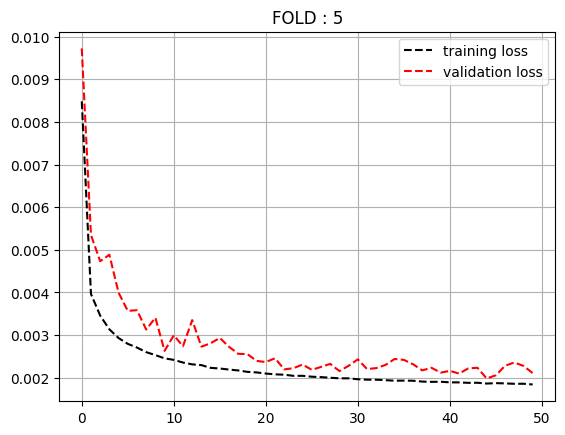

In [18]:
kf = KFold(n_splits=5)
X=df['noisy']
Y=df['ground_truth']
latent_dim=64
for split_no,(train_index,test_index) in enumerate(kf.split(X)):
  print("############################")
  print("#####   SPLIT : {}   #######".format(split_no+1))
  print("############################")

  X_train=X[train_index]
  X_test=X[test_index]
  y_train=Y[train_index]
  y_test=Y[test_index] 

  print(X_train.shape)
  print(y_train.shape)
  print(X_test.shape)
  print(y_test.shape)

  X_train_patches = []
  y_train_patches = []
  for i in range(len(X_train)):
    path = X_train.iloc[i]
    img_nsy = cv2.imread(path)
    img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
    
    img_nsy = cv2.resize(img_nsy,(256,256))  #resizing the X_train images
    patches_nsy = patches(img_nsy,32)
    
    path = y_train.iloc[i]
    img_gt = cv2.imread(path)
    img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
    img_gt = cv2.resize(img_gt,(256,256))  #resizing the y_train images
    patches_gt = patches(img_gt,32)
    # X_train_patches.append(patches_nsy)
    # y_train_patches.append(patches_gt)
    rows = patches_nsy.shape[0]
    cols = patches_nsy.shape[1]
    for j in range(rows):
      for k in range(cols):
        X_train_patches.append(patches_nsy[j][k][0])
        y_train_patches.append(patches_gt[j][k][0])
    
  X_train_patches = np.array(X_train_patches)
  y_train_patches = np.array(y_train_patches)
  print(X_train_patches.shape)
  print(y_train_patches.shape)

  #Creating patches for X_test and y_test
  X_test_patches = []
  y_test_patches = []
  for i in range(len(X_test)):
    path = X_test.iloc[i]
    img_nsy = cv2.imread(path)
    img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
    img_nsy = cv2.resize(img_nsy,(256,256))  #resizing the X_test images
    patches_nsy = patches(img_nsy,32)
    
    path = y_test.iloc[i]
    img_gt = cv2.imread(path)
    img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
    img_gt = cv2.resize(img_gt,(256,256))  #resizing the y_test images
    patches_gt = patches(img_gt,32)

    rows = patches_nsy.shape[0]
    cols = patches_nsy.shape[1]
    for j in range(rows):
      for k in range(cols):
        X_test_patches.append(patches_nsy[j][k][0])
        y_test_patches.append(patches_gt[j][k][0])

  X_test_patches = np.array(X_test_patches)
  y_test_patches = np.array(y_test_patches)


  print(X_train_patches.shape)
  print(y_train_patches.shape)
  print(X_test_patches.shape)
  print(y_test_patches.shape)


  print("Total number of image patches on train data : ", (X_train_patches.shape))
  print("Total number of image patches on test data : ", (X_test_patches.shape))
     
  #normalize the image patches
  X_train_patches = X_train_patches.astype("float32") / 255.0
  y_train_patches = y_train_patches.astype("float32") / 255.0
  X_test_patches = X_test_patches.astype("float32") / 255.0
  y_test_patches = y_test_patches.astype("float32") / 255.0

  batch_size=32
  train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
  test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)
  print(train_dataloader[0][0].shape)

  auto_encoder=Autoencoder(latent_dim)
  auto_encoder.compile(optimizer=optimizers.Adam(learning_rate=1e-3),loss=tf.keras.losses.MeanSquaredError())
  # auto_encoder.compile(optimizer='adam',loss='mse')

  checkpoint_path = "training_{}/cp.ckpt".format(split_no+1)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      monitor='val_loss',
      mode='min',
      save_best_only=True,
      verbose=True)

  #train 
  history=auto_encoder.fit(X_train_patches,y_train_patches,
                  epochs=EPOCHS,
                  shuffle=True,
                  callbacks=[model_checkpoint_callback],
                  validation_data=(X_test_patches,y_test_patches))

  #plot the loss and accuracy plot
  plt.plot(history.history['loss'],'k--')
  plt.plot(history.history['val_loss'],'r--')
  plt.legend(['training loss','validation loss'])
  plt.grid()
  plt.title("FOLD : {}".format(split_no+1))
  plt.show()



In [19]:
def predict(img,model,verbose=True):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(256,256))
  img=img.astype("float32")/255.0

  img_patches=patches(img,32)

  noisy_patches=[]
  for i in range(8):
    for j in range(8):
      noisy_patches.append(img_patches[i][j][0])
  noisy_patches=np.array(noisy_patches)

  pred_img=model.predict(noisy_patches,verbose=verbose)
  pred_img=np.reshape(pred_img,(8,8,1,32,32,3))
  pred_img=unpatchify(pred_img,img.shape)
  return pred_img

### Load from checkpoint

In [38]:
from prettytable import PrettyTable
data_noisy15 = PrettyTable()
data_noisy15.field_names=["Fold No.","PSNR mean","PSNR STD","SSIM mean","SSIM std"]
data_noisy25 = PrettyTable()
data_noisy25.field_names=["Fold No.","PSNR mean","PSNR STD","SSIM mean","SSIM std"]


for split_no in range(5):
  # print("############################")
  # print("#####   SPLIT : {}   #######".format(split_no+1))
  # print("############################")

  checkpoint_path = "training_{}/cp.ckpt".format(split_no+1)
  model_1 = Autoencoder(latent_dim)
  model_1.load_weights(checkpoint_path).expect_partial()
  psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test,y_test,model_1)


  # print("----------- NOISY 15 -------------")
  test_set_path='/content/drive/MyDrive/noisy15/*.png'
  original_file_path='/content/drive/MyDrive/original_png/'
  file_names=glob(test_set_path)
  X_test_68=[]
  y_test_68=[]
  for file in file_names:
    input_name=file.split('/')[-1]
    X_test_68.append(file)
    y_test_68.append(original_file_path+input_name)

  psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test_68,y_test_68,model_1,test_68=True)
  data_noisy15.add_row([split_no+1,np.mean(psnr_list),np.std(psnr_list),np.mean(ssim_list),np.std(ssim_list)])
  # print('PSNR before denoising :', psnr_nsy)
  # print('PSNR after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(psnr_list),np.std(psnr_list)))
  # print('SSIM before denoising :', ssim_nsy)
  # print('SSIM after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(ssim_list),np.std(ssim_list)))

  # print("----------- NOISY 25 -------------")
  test_set_path='/content/drive/MyDrive/noisy25/*.png'
  original_file_path='/content/drive/MyDrive/original_png/'
  file_names=glob(test_set_path)
  X_test_68=[]
  y_test_68=[]
  for file in file_names:
    input_name=file.split('/')[-1]
    X_test_68.append(file)
    y_test_68.append(original_file_path+input_name)

  psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test_68,y_test_68,model_1,test_68=True)
  data_noisy25.add_row([split_no+1,np.mean(psnr_list),np.std(psnr_list),np.mean(ssim_list),np.std(ssim_list)])
  # print('PSNR before denoising :', psnr_nsy)
  # print('PSNR after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(psnr_list),np.std(psnr_list)))
  # print('SSIM before denoising :', ssim_nsy)
  # print('SSIM after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(ssim_list),np.std(ssim_list)))

print("---------- NOISY 15 ------------")
print(data_noisy15)

print("---------- NOISY 25 ------------")
print(data_noisy25)
  

---------- NOISY 15 ------------
+----------+--------------------+--------------------+--------------------+----------------------+
| Fold No. |     PSNR mean      |      PSNR STD      |     SSIM mean      |       SSIM std       |
+----------+--------------------+--------------------+--------------------+----------------------+
|    1     | 25.298772579628686 | 2.6437361974965574 | 0.8507938001700173 | 0.06181973057859718  |
|    2     | 25.22061342335237  | 2.7119620799065918 | 0.8513436169286281 | 0.062062193168393114 |
|    3     | 24.856332973484083 | 2.7156927929594383 | 0.8504542429120459 | 0.06330919432800897  |
|    4     | 24.855992224025535 | 2.685067853095216  | 0.8498120431887846 | 0.061428014827960335 |
|    5     | 24.918122563144674 | 2.713932299496779  | 0.8449511763253843 | 0.06290355340253721  |
+----------+--------------------+--------------------+--------------------+----------------------+
---------- NOISY 25 ------------
+----------+--------------------+----------

In [ ]:
split_no=1
checkpoint_path = "training_{}/cp.ckpt".format(split_no+1)
model_1 = Autoencoder(latent_dim)
model_1.load_weights(checkpoint_path)
test_set_path='/content/drive/MyDrive/noisy15/*.png'
output_path='noisy_15/'
file_names=glob(test_set_path)
count=0
for file_path in file_names:
  count +=1
  nsy=cv2.imread(file_path)

  pred = predict(nsy,model_1,verbose=False)
  # print(np.min(pred),np.max(pred))
  pred=np.uint8(255*(pred-np.min(pred))/(np.max(pred)-np.min(pred)))
  input_name=file_path.split('/')[-1]
  cv2.imwrite(output_path+input_name,pred)
  if count % 10==0:
    print("[info] processed : {} / {}".format(count,len(file_names)))
